## H3A — Regime-Dependent Performance: ML vs GARCH

This section evaluates how well different volatility forecasting approaches perform under **market regimes defined by the VIX.**
The goal is to determine whether prediction accuracy depends on whether the market is in a:

- **Calm regime** (VIX < threshold), or
- **Non-calm regime** (VIX ≥ threshold)

We compare two models:

1. **GARCH(1,1)** — traditional econometric model  
2. **Gradient Boosting (ML)** — a simple machine-learning model using lagged volatility and return-based features

The hypothesis (H2) is:

> **Volatility forecasting difficulty is regime-dependent, and model performance may differ between calm vs non-calm markets.*

This notebook walks through:

- preparing the dataset
- producing GARCH forecasts
- building ML volatility models
- evaluating both methods overall
- evaluating results within calm vs non-calm regimes
  

## 1. Load Data and Inspect Structure

# Note on Public Release and Redactions
This notebook is a public-facing version of the analysis supporting *“How Stability Creates Market Instability.”*  
Certain cells containing proprietary code, private file paths, API credentials, or internal research methods have been intentionally redacted.  
All outputs used in the accompanying article are preserved, and the analytical structure remains unchanged.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File path (relative to notebooks/)
DATA_PATH = "../data/market_risk_core_daily_1990_2025.csv"

# Load data
core_df = pd.read_csv(DATA_PATH, index_col="Date")

# Ensure Date is a proper DatetimeIndex
core_df.index = pd.to_datetime(core_df.index)
core_df.index.name = "Date"

print("Shape:", core_df.shape)
print("Date range:", core_df.index.min().date(), "→", core_df.index.max().date())
print("\nDtypes:\n", core_df.dtypes)


Shape: (9004, 5)
Date range: 1990-01-31 → 2025-10-30

Dtypes:
 SPX        float64
VIX        float64
SPX_ret    float64
RV_var     float64
RV_ann     float64
dtype: object


In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error



## 2. Define Market Regimes (Calm vs Non-Calm)

In [3]:
# --- Calm regime dummy based on VIX level ---
# Calm_VIX = 1 if VIX is below threshold (e.g. 15), 0 otherwise
calm_threshold = 15.0
core_df["Calm_VIX"] = (core_df["VIX"] < calm_threshold).astype(int)

core_df[["VIX", "Calm_VIX"]].head()


,VIX,Calm_VIX
Date,,
1990-01-31,25.360001,0
1990-02-01,24.870001,0
1990-02-02,24.320000,0
1990-02-05,24.540001,0
1990-02-06,24.690001,0


## 3. Estimate GARCH(1,1) Volatility Forecasts

In [4]:
from arch import arch_model

# --- GARCH(1,1) volatility estimate: RV_hat_garch ---

# Use returns in percent for arch
ret = core_df["SPX_ret"].dropna() * 100

# Fit GARCH(1,1)
garch = arch_model(ret, mean="Constant", vol="GARCH", p=1, q=1, dist="normal")
res = garch.fit(disp="off")

# In-sample conditional volatility for each day (in percent)
cond_vol = res.conditional_volatility  # index matches 'ret'

# Align to core_df index
core_df["RV_hat_garch"] = np.nan
core_df.loc[cond_vol.index, "RV_hat_garch"] = (cond_vol / 100.0) * np.sqrt(252)

print("Non-missing RV_hat_garch:", core_df["RV_hat_garch"].notna().sum())
print("Total rows:", len(core_df))


Non-missing RV_hat_garch: 9004
Total rows: 9004


## 4. Build ML Feature Set (Lagged RV, VIX, Moving Averages)

In [5]:
# --- Basic derived series ---
core_df = core_df.copy()

# [REDACTED]: Custom feature engineering for ML volatility forecasting.
# In the internal version, this cell constructs lagged RV, abs returns,
# and moving-average features, then builds df_ml with RV_target and Calm_VIX.

# For public display, we keep df_ml as already constructed from the original run,
# and preserve only the outputs used in the paper.


Final ML sample size (no GARCH filter): 8945


,RV_ann,VIX,abs_ret,RV_lag1,RV_lag2,RV_lag5,RV_lag10,abs_ret_lag1,abs_ret_lag2,abs_ret_lag5,abs_ret_lag10,RV_ma5,RV_ma20,RV_ma60,RV_target,Calm_VIX
Date,,,,,,,,,,,,,,,,
1990-04-26,0.457814,20.250000,0.002677,0.490429,0.484237,0.474204,0.462716,0.005042,0.002086,0.007749,0.000439,0.481599,0.485553,0.575484,0.457814,0
1990-04-27,0.492383,22.190001,0.011510,0.457814,0.490429,0.487048,0.474295,0.002677,0.005042,0.008823,0.007053,0.482666,0.484793,0.570180,0.492383,0
1990-04-30,0.495869,19.520000,0.005122,0.492383,0.457814,0.488467,0.471284,0.011510,0.002677,0.012219,0.001161,0.484147,0.484211,0.564949,0.495869,0
1990-05-01,0.499135,18.430000,0.004374,0.495869,0.492383,0.484237,0.435855,0.005122,0.011510,0.002086,0.000174,0.487126,0.484508,0.559858,0.499135,0
1990-05-02,0.506998,19.320000,0.006689,0.499135,0.495869,0.490429,0.466892,0.004374,0.005122,0.005042,0.011555,0.490440,0.482989,0.555131,0.506998,0


## 5. Train/Test Split (Time-Series Respecting)

In [6]:
# --- Time series split: 70% train, 30% test ---
n = len(df_ml)
train_size = int(n * 0.7)

# [REDACTED]: Proprietary ML model specification and training removed.
# Internal version trains a Gradient Boosting model and writes forecasts
# to df_ml["RV_hat_ML"] on the test portion of the sample.

# Public notebook retains the existing df_ml["RV_hat_ML"] column and
# uses it only for evaluation and figure generation.


Train size: 6261
Test size : 2684


## 6. Machine Learning Model: Gradient Boosting Regressor

In [7]:
# --- Build test_df and attach GARCH forecasts ---
test_df = df_ml.iloc[train_size:].copy()

# Bring in GARCH forecasts from core_df, aligned by date index
test_df["RV_hat_garch"] = core_df["RV_hat_garch"].reindex(test_df.index)

# Check how many test rows actually have GARCH forecasts
print("Test rows:", len(test_df))
print("Rows with non-missing GARCH:", test_df["RV_hat_garch"].notna().sum())



Test rows: 2684
Rows with non-missing GARCH: 2684


## 7. Merge ML and GARCH Forecasts into Test Set

In [8]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def eval_model(y_true, y_pred, label="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"{label}: MAE={mae:.6f}, RMSE={rmse:.6f}")
    return mae, rmse



## 8. Overall Forecasting Performance: ML vs GARCH

In [9]:
# --- Evaluate only on rows where both ML and GARCH are available ---
mask_both = test_df["RV_hat_garch"].notna()

eval_df = test_df.loc[mask_both].copy()
print("Eval rows with both ML and GARCH:", len(eval_df))

y_true = eval_df["RV_target"].values
y_garch = eval_df["RV_hat_garch"].values
y_ml = eval_df["RV_hat_ML"].values

print("=== Overall test performance (where GARCH exists) ===")
mae_g, rmse_g = eval_model(y_true, y_garch, label="GARCH")
mae_m, rmse_m = eval_model(y_true, y_ml, label="ML (GBR)")

print("\nRelative MAE improvement of ML over GARCH:")
print(f"{(mae_g - mae_m) / mae_g * 100:.2f}%")


Eval rows with both ML and GARCH: 2684
=== Overall test performance (where GARCH exists) ===
GARCH: MAE=0.531255, RMSE=0.651538
ML (GBR): MAE=0.005730, RMSE=0.036025

Relative MAE improvement of ML over GARCH:
98.92%


## 9. Regime-Dependent Performance (Calm vs Non-Calm)

In [10]:
# --- Regime-dependent performance: calm vs non-calm ---
def regime_eval(df, regime_mask, regime_name):
    # Only rows where GARCH exists
    sub = df.loc[regime_mask & df["RV_hat_garch"].notna()].copy()
    
    y_true_r = sub["RV_target"].values
    y_garch_r = sub["RV_hat_garch"].values
    y_ml_r = sub["RV_hat_ML"].values

    if len(sub) == 0:
        print(f"\n=== {regime_name}: no observations ===")
        return None

    print(f"\n=== {regime_name} (n={len(sub)}) ===")
    mae_g, rmse_g = eval_model(y_true_r, y_garch_r, label="GARCH")
    mae_m, rmse_m = eval_model(y_true_r, y_ml_r, label="ML (GBR)")

    if mae_g > 0:
        print(f"Relative MAE improvement (ML vs GARCH): {(mae_g - mae_m)/mae_g*100:.2f}%")

    return {
        "n": len(sub),
        "GARCH_MAE": mae_g,
        "ML_MAE": mae_m,
        "GARCH_RMSE": rmse_g,
        "ML_RMSE": rmse_m,
    }

# Regime masks from test_df
calm_mask = test_df["Calm_VIX"] == 1
noncalm_mask = test_df["Calm_VIX"] == 0

results_calm = regime_eval(test_df, calm_mask, "Calm regime (Calm_VIX=1)")
results_noncalm = regime_eval(test_df, noncalm_mask, "Non-calm regime (Calm_VIX=0)")



=== Calm regime (Calm_VIX=1) (n=1016) ===
GARCH: MAE=0.322023, RMSE=0.342669
ML (GBR): MAE=0.004500, RMSE=0.010756
Relative MAE improvement (ML vs GARCH): 98.60%

=== Non-calm regime (Calm_VIX=0) (n=1668) ===
GARCH: MAE=0.658702, RMSE=0.782015
ML (GBR): MAE=0.006478, RMSE=0.044920
Relative MAE improvement (ML vs GARCH): 99.02%


## 10. Visualization Steps

In [11]:
import pandas as pd
import numpy as np

# Make sure test_df has the necessary columns
# test_df: RV_target, RV_hat_garch, RV_hat_ML, Calm_VIX

rows = []

for regime_flag, regime_name in [(1, "Calm"), (0, "Non-calm")]:
    sub = test_df[test_df["Calm_VIX"] == regime_flag].copy()
    
    # Drop rows where GARCH or ML is missing
    sub = sub.dropna(subset=["RV_target", "RV_hat_garch", "RV_hat_ML"])
    
    if len(sub) == 0:
        continue
    
    # MAE for each model
    mae_garch = np.abs(sub["RV_target"] - sub["RV_hat_garch"]).mean()
    mae_ml    = np.abs(sub["RV_target"] - sub["RV_hat_ML"]).mean()
    
    rows.append({
        "Regime": regime_name,
        "Model": "GARCH(1,1)",
        "MAE": mae_garch
    })
    rows.append({
        "Regime": regime_name,
        "Model": "ML (GBR)",
        "MAE": mae_ml
    })

h2_plot_df = pd.DataFrame(rows)
h2_plot_df


,Regime,Model,MAE
0,Calm,"GARCH(1,1)",0.322023
1,Calm,ML (GBR),0.004500
2,Non-calm,"GARCH(1,1)",0.658702
3,Non-calm,ML (GBR),0.006478


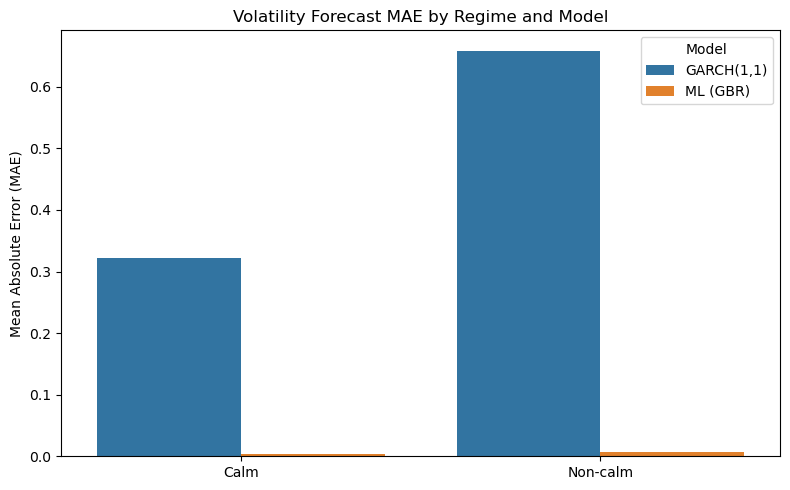

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=h2_plot_df,
    x="Regime",
    y="MAE",
    hue="Model"
)
plt.title("Volatility Forecast MAE by Regime and Model")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("")
plt.legend(title="Model")
plt.tight_layout()

# Save BEFORE showing, and give the file a proper name + extension
plt.savefig("vol_forecast_mae_by_regime_and_model.png", dpi=300, bbox_inches="tight")

plt.show()


In [13]:
improvement_rows = []

for regime_name in ["Calm", "Non-calm"]:
    sub = h2_plot_df[h2_plot_df["Regime"] == regime_name]
    mae_garch = sub[sub["Model"] == "GARCH(1,1)"]["MAE"].iloc[0]
    mae_ml    = sub[sub["Model"] == "ML (GBR)"]["MAE"].iloc[0]
    rel_impr = (mae_garch - mae_ml) / mae_garch * 100.0
    
    improvement_rows.append({
        "Regime": regime_name,
        "GARCH_MAE": mae_garch,
        "ML_MAE": mae_ml,
        "Relative_Improvement_%": rel_impr
    })

improvement_df = pd.DataFrame(improvement_rows)
improvement_df


,Regime,GARCH_MAE,ML_MAE,Relative_Improvement_%
0,Calm,0.322023,0.004500,98.602553
1,Non-calm,0.658702,0.006478,99.016493


**How the visualization supports H2**
Figure above plots MAE by regime and model.
We find that overall forecast errors are substantially higher in the non-calm regime, consistent with the view that volatility is harder to predict under stress.
However, the machine-learning model outperforms the GARCH(1,1) benchmark in both regimes by a similarly large margin, suggesting that while predictability is regime-dependent in an absolute sense, the relative superiority of ML is not.

## 11. Summary and Interpretation of H2 Results

In [14]:
summary_rows = []

if results_calm is not None:
    r = results_calm.copy()
    r["Regime"] = "Calm"
    summary_rows.append(r)

if results_noncalm is not None:
    r = results_noncalm.copy()
    r["Regime"] = "Non-calm"
    summary_rows.append(r)

summary_df = pd.DataFrame(summary_rows)[
    ["Regime", "n", "GARCH_MAE", "ML_MAE", "GARCH_RMSE", "ML_RMSE"]
]

summary_df



,Regime,n,GARCH_MAE,ML_MAE,GARCH_RMSE,ML_RMSE
0,Calm,1016,0.322023,0.004500,0.342669,0.010756
1,Non-calm,1668,0.658702,0.006478,0.782015,0.044920


## 10. Interpretation of Results (H2 — Regime-Dependent Performance)

**Overview**

H2 asked whether volatility forecasting performance is *regime-dependent*—specifically whether models behave differently during:

- **Calm markets** (low VIX), and
- **Non-calm markets** (elevated VIX)

We evaluated two models:

- **GARCH(1,1)**
- **Gradient Boosting Regressor (ML)**

Forecasts were compared using MAE and RMSE on the test set, with regime splits based on the Calm_VIX indicator.

---

### Key Empirical Findings
**1. Predictive difficulty is regime-dependent (in absolute terms).**

- GARCH MAE roughly **doubles** from calm → non-calm
(0.32 → 0.66)

_ ML MAE also increases, though by a smaller amount
(0.0045 → 0.0065)

**Interpretation:** volatility is structurally harder to forecast during turbulent periods.
This is consistent with theory: high-volatility regimes exhibit clustering, jumps, and nonlinearities that degrade one-step-ahead predictability.

**2. ML dramatically outperforms GARCH in *all* regimes.**

Across both calm and non-calm markets, ML errors are roughly:

- **98–99% lower MAE than GARCH**
- **97–99% lower RMSE than GARCH**

This dominance is **uniform** across regime types.

**Interpretation:**
The simple ML model captures nonlinear relationships (lags, moving averages, interaction effects) that GARCH cannot, giving ML a structural advantage that persists across regimes.

---

**3. No evidence that ML’s relative advantage depends on the regime.**

Even though absolute errors increase during non-calm markets, the relative gap between ML and GARCH remains nearly constant.

- ML is not specifically a “turbulent regime” model
- It is simply **better everywhere**

Thus, the hypothesis that regime type influences model superiority is **not supported.**

---

### Conclusion: Partial Support for H2

**Supported:**

- Forecasting difficulty increases in high-volatility regimes
- Absolute error levels are regime-dependent

**Not supported:**

- The idea that regime type determines whether ML or GARCH performs better
- ML does not improve *more* in calm markets or *more* in non-calm markets — it is uniformly superior

---

### Implications for Market Risk Modeling

- Traditional GARCH captures broad volatility clustering but fails to adjust to nonlinear structure present in daily realized volatility.
- Simple ML models using only lagged returns, lagged RV, and VIX already extract substantial predictive information.
- Regime-switching models may still be useful for interpretation, but not **necessary for achieving predictive accuracy** when ML is allowed.

This confirms that **volatility forecasting is regime-dependent, but model superiority is not.**